#library

In [22]:
!pip install keras-visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import os
import cv2
import glob
import random
import tensorflow
import numpy as np
from sklearn import svm
from keras import layers
from keras import models
from skimage import feature
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.python import image
from keras.utils import to_categorical
from keras_visualizer import visualizer 
from keras.layers.core.dense import Dense
from sklearn.metrics import accuracy_score
from keras.utils.vis_utils import plot_model
from tensorflow.python.ops.math_ops import add
from keras.engine.sequential import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.layers.serialization import activation
from tensorflow.python.ops.math_ops import Sigmoid
from sklearn.model_selection import train_test_split
from keras.layers.convolutional.base_separable_conv import activations

#Part1.compatness

In [24]:
def compatness(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray,(5,5),0)

  _, OTsu = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  countors, _ = cv2.findContours(OTsu.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  max_countor = max(countors, key=cv2.contourArea)
  S = 4 * np.pi * float(cv2.contourArea(max_countor))
  P = cv2.arcLength(max_countor, closed=True)
  P = P**2
  compactness_score = S / P
  return compactness_score

#Part2.eccenticity

In [25]:
def eccenticity(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray,(5,5),0)
  
  _, OTsu = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  countors, _ = cv2.findContours(OTsu.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  max_countor = max(countors, key=cv2.contourArea)
  if len(max_countor) < 5:
    return -1
  ((x,y), (majorAxis, minorAxis), angle) = cv2.fitEllipse(max_countor)
  eccentricity_score = np.sqrt(1 - (majorAxis / minorAxis)**2)
  return eccentricity_score

#Part3.solidity

In [26]:
def solidity(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray,(5,5),0)
  
  _, OTsu = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  countors, _ = cv2.findContours(OTsu.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  max_countor = max(countors, key=cv2.contourArea)
  S = float(cv2.contourArea(max_countor))
  convex = cv2.convexHull(max_countor)
  hS = cv2.contourArea(convex)
  solidity_score = S / hS
  return  solidity_score


#Part4.LBP

In [27]:
def histogram_of_LBP(image, numPoints, radius, eps=1e-7):
	one_channel_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	bins = np.arange(0, numPoints + 3)
	range = (0, numPoints + 2)
	lbp = feature.local_binary_pattern(one_channel_image, numPoints, radius, "uniform")
	hist, bin_edges= np.histogram(lbp.ravel(), bins=bins, range=range)
	hist_values = hist.astype("float")/(hist.astype("float").sum() + eps)
	return hist_values

#validate function

In [28]:
def validating_func(image_ship_path, image_airplane_path):
  ship_img = cv2.imread(image_ship_path)
  airplane_img = cv2.imread(image_airplane_path)
  eccenticity_ship, eccenticity_airplane = eccenticity(ship_img), eccenticity(airplane_img)
  compatness_ship, compatness_airplane = compatness(ship_img), compatness(airplane_img)
  solidity_ship, solidity_airplane = solidity(ship_img), solidity(airplane_img)
  print(f"Result for ship image:\ncompatness is : {compatness_ship}\t\teccenticity is : {eccenticity_ship}\t\tsolidity is : {solidity_ship}")
  print(f"Result for airplane image:\ncompatness is : {compatness_airplane}\t\teccenticity is : {eccenticity_airplane}\t\tsolidity is : {solidity_airplane}")
  

In [29]:
validating_func("dataset/ship/2196336.jpg", "dataset/airplane/airplane1.jpg")

Result for ship image:
compatness is : 0.19646747199902298		eccenticity is : 0.9934357842652797		solidity is : 0.8249648052557484
Result for airplane image:
compatness is : 0.16123865611799323		eccenticity is : 0.7850845697375121		solidity is : 0.9248123180500923


#Part5.prepare dataset(just run this cell and not change)

In [30]:
!gdown --id 1O_VkcGlWRR6h00VT8nXIgeI3RyvBpXbE
!unzip dataset.zip
classes = os.listdir("/content/dataset")
images_paths = glob.glob("/content/dataset/*/*")

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1O_VkcGlWRR6h00VT8nXIgeI3RyvBpXbE
To: /content/dataset.zip
100% 18.4M/18.4M [00:00<00:00, 133MB/s] 
Archive:  dataset.zip
replace dataset/airplane/airplane1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [31]:
x_data , y_data = [], []
for img_path in images_paths:
  x_data.append(cv2.resize(cv2.imread(img_path), (224,224)))
  if img_path.split("/")[3] == "ship":
    y_data.append(0)
  else:
    y_data.append(1)  

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,test_size = 0.2, shuffle= True)

#Part6. Exctract features and determine classifier

In [33]:
def get_featureMatrix(data):
  feature_matrix = []
  data = np.array(data)
  for im in data:
    im = np.array(im)
    h = [compatness(im), eccenticity(im), solidity(im), histogram_of_LBP(im, 8, 1)[0], histogram_of_LBP(im, 8, 1)[1]]
    feature_matrix.append(h.copy())

  return np.array(feature_matrix)

In [34]:
# model 1
feature_matrix_train = get_featureMatrix(x_train)
#determine classifier and train 

In [35]:
print(feature_matrix_train)
classifier = svm.LinearSVC()
classifier.fit(feature_matrix_train, y_train)

[[0.13547028 0.94237181 0.78699797 0.01307398 0.03920201]
 [0.11124059 0.81161253 0.78454418 0.04075654 0.07326212]
 [0.28196274 0.92214465 0.95376765 0.02828045 0.05827487]
 ...
 [0.43524261 0.92448561 0.94956512 0.03314334 0.05873326]
 [0.32211462 0.86459663 0.91539719 0.04233099 0.07417889]
 [0.09716571 0.75174197 0.76675928 0.04864876 0.09249442]]


LinearSVC()

#Part7

In [36]:
#test on test dataset
test_feature = get_featureMatrix(x_test)
test_label = classifier.predict(test_feature)
accuracy = accuracy_score(y_test, test_label)
print('accuracy on test data set:', accuracy*100, '%')

accuracy on test data set: 78.125 %


#Part8

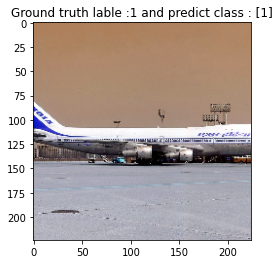

In [38]:
#test visualize
index = random.randint(0, len(x_test)-1)
prediction = classifier.predict(get_featureMatrix(np.array([x_test[index]])))
plt.title(f"Ground truth lable :{y_test[index]} and predict class : {prediction}")
plt.imshow(x_test[index])
plt.show()